In [1]:
#Import the required libraries
import matplotlib.pyplot as pyplot
import matplotlib.image as img
import numpy 
    #You will need to install the cv package, you can try with conda install -c menpo opencv3
import cv2
import os
import math
    # Import everything needed to edit/save/watch video clips, you will need ffmpeg installed,
    #do it from python by running this: imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
#DETECT LINES PROCESSES AN INPUT IMAGE AND RETURNS AN OUTPUT IMAGE WITH THE LINES DETECTED
def process_image(inImg,outputImage=7):
    #Output Image Indicates whats the image you want to retrieve these are the options:
        #0 White and black image containing all bright yellow and white objects as white, black elsewhere
        #1 Image with the Edges Detected using Cannys Algorithm
        #2 Mask of interest Area
        #3 Masked version of the edges image with the area of interest
        #4 Images with all the lines detected with the Houghs transformation
        #5 Average left and right lines
        #6 expansion of the previous Image to cover the entire area of interest
        #7 Final Image
            
    #from the original image identify yellow and white colors
    R=inImg[:,:,0]
    G=inImg[:,:,1]
    B=inImg[:,:,2]
    yellowPixels=numpy.logical_and(numpy.logical_and(numpy.logical_and((numpy.greater(R,numpy.ones_like(R)*130)), \
                                                        numpy.greater(G,numpy.ones_like(G)*130)), \
                                                        numpy.less(B,numpy.ones_like(B)*180)), \
                                                        numpy.greater(numpy.absolute(R-G),numpy.ones_like(R)*20))
    whitePixels=numpy.logical_and(numpy.logical_and(numpy.greater(R,numpy.ones_like(R)*180),\
                                                        numpy.greater(G,numpy.ones_like(G)*180)),\
                                                        numpy.greater(B,numpy.ones_like(B)*180))
    ywPixels=1*numpy.logical_or(yellowPixels,whitePixels)
    
    ywImg=numpy.zeros_like(inImg)
    ywImg[:,:,0]=ywPixels*255
    ywImg[:,:,1]=ywPixels*255
    ywImg[:,:,2]=ywPixels*255
    orgImg=ywImg
    #Blur
    ImgBlur=cv2.GaussianBlur(ywImg,(3,3),0)
    #Identify Edges using the Canny edges Algorithm
    minGradient=175
    maxGradient=200
    edgesImg=cv2.Canny(ImgBlur,minGradient,maxGradient)
    #Masked Version of the Edges Image
    #Create Mask
    maxX=numpy.size(edgesImg,1)
    maxY=numpy.size(edgesImg,0)
    Vertices=numpy.array([[[0,0],[0,0],[0,0],[0,0]]], dtype=numpy.int32)
    topLimit=maxY/2+maxY/8
    Vertices[0][0]=[0,maxY]
    Vertices[0][1]=[maxX/2-maxX/20,topLimit]
    Vertices[0][2]=[maxX/2+maxX/20,topLimit]
    Vertices[0][3]=[maxX,maxY]
    mask=numpy.zeros_like(edgesImg, dtype=numpy.uint8)
    cv2.fillPoly(mask,Vertices,255)
    #Apply Mask on Edges Image
    maskedImg=numpy.bitwise_and(mask,edgesImg)
    #Houghs Transform to identify Lines
    rho=1                 #resolution on rho axis in Hough Space
    theta=3*math.pi/180   #resolution on theta axis on Hough Space 1 degree
    threshold=3           #min number of intersections in Hough Space to be considered a line
    min_line_len=20       #Min length of found lines in pixels to not discart them
    max_line_gap=5      #Max number of pixels between lines before considering a single large line
        #Lines is a vector of vectors, each vector has a line parameter which is a vector with the x1,y1,x2,y2 of line 
    lines = cv2.HoughLinesP(maskedImg, rho, theta, threshold, numpy.array([]), minLineLength=min_line_len, \
                            maxLineGap=max_line_gap)
    totLines=numpy.size(lines,0)
    allLinesImg=numpy.zeros_like(orgImg)
    redColor=[255,0,0]
    lineThickness=3
    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate the slope of the current line
            allLinesImg=cv2.line(allLinesImg, (x1,y1), (x2,y2), redColor, lineThickness)
    #Simplify Lines, only consider those with absolute slope 0.5<= X <=2
        #From those detect the positives(left side) and negatives (right side)
        #for each side calculate the average
    linesSlope=numpy.zeros(totLines)
    lineThickness=5
    counter=0
        #initial values the extrema of the values worst case
    leftSumSlope=0
    leftSlopeCount=0
    rightSumSlope=0
    rightSlopeCount=0
    leftBiasSum=0
    rightBiasSum=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate the slope of the current line
            linesSlope[counter]=(y2-y1)/(x2-x1)
            if ((linesSlope[counter]<(-0.5))and(linesSlope[counter]>(-1))):
                lineLength=math.sqrt(math.pow((y2-y1),2)+(math.pow((x2-x1),2)))
                #Left Side Line for weightened Average (Length si the factor)
                leftSumSlope=leftSumSlope+linesSlope[counter]*lineLength
                leftSlopeCount=leftSlopeCount+lineLength
                #Bias sum for average if y=mx+b =>b=y-mx (Weightened by the length)
                leftBiasSum=leftBiasSum+(y2-linesSlope[counter]*x2)*lineLength
            if ((linesSlope[counter]>0.5) and (linesSlope[counter]<1)):
                #Right Side Line for weightened Average (Length si the factor)
                lineLength=math.sqrt(math.pow((y2-y1),2)+(math.pow((x2-x1),2)))
                rightSumSlope=rightSumSlope+linesSlope[counter]*lineLength
                rightSlopeCount=rightSlopeCount+lineLength
                #Bias sum for average if y=mx+b =>b=y-mx (Weightened by the length)
                rightBiasSum=rightBiasSum+(y2-linesSlope[counter]*x2)*lineLength
        counter+=+1
    
    #Lines exist?
    if leftSlopeCount>0:
        leftExists=True
    else:
        leftExists=False
    if rightSlopeCount>0:
        rightExists=True
    else:
        rightExists=False
    #Draw the 2 mainLines detected as a combination of all the little lines detected
    detLinesImg=numpy.copy(orgImg)
        #LeftLine
    if leftExists:
        #Calculate the average slopes and the points for the left and right lines
        leftLineSlope=leftSumSlope/leftSlopeCount
        #Calculate the end and start positions
        leftLineBias=leftBiasSum/leftSlopeCount #same weight factor as the slope so same counter
        #Calculate max and min points y=mx+b x=(y-b)/m rounded down
        #Min and Max X are swaped because the axis is the opposite as in a cartesian plane
        leftMinY=0
        leftMaxX=math.floor((leftMinY-leftLineBias)/(leftLineSlope))
        leftMaxY=maxY
        leftMinX=math.floor((leftMaxY-leftLineBias)/(leftLineSlope))
        #Draw the line
        detLinesImg=cv2.line(detLinesImg, (leftMinX, leftMaxY), (leftMaxX, leftMinY), redColor, lineThickness)
        #RightLine
    if rightExists:
        #Calculate the average slopes and the points for the left and right lines
        rightLineSlope=rightSumSlope/rightSlopeCount
        #Calculate the end and start positions
        rightLineBias=rightBiasSum/rightSlopeCount #same weight factor as the slope so same counter
        #Calculate max and min points y=mx+b x=(y-b)/m rounded down
        #Min and Max X are swaped because the axis is the opposite as in a cartesian plane
        rightMinY=0
        rightMinX=math.floor((rightMinY-rightLineBias)/(rightLineSlope))
        rightMaxY=maxY
        rightMaxX=math.floor((rightMaxY-rightLineBias)/(rightLineSlope))
        #Draw the line
        detLinesImg=cv2.line(detLinesImg, (rightMinX, rightMinY), (rightMaxX, rightMaxY), redColor, lineThickness)
        
    #Build the Boundaries (extend the 2 main lines detected doen to the bottom of the screen to create a path)
            #The lines of the path will have the same slopes as the lines detected and the same bias
            #However they will run all the way down to the bottom of the picture and all the way up to the center of the screen
    lineThickness=15
    boundImg=numpy.ones_like(orgImg)*255
    
    #Left Boundary
    if leftExists:
        #Equation y=mX+B =>  Bias=y-mX where m=leftLineSlope and at one of the points y=leftMaxY x=leftMinX
        leftBias=leftMaxY-leftLineSlope*leftMinX
        #Now that we have m and B we can have y for any value of x and viceversa x=(y-B)/m
        leftP1=numpy.int32(numpy.array([(maxY-leftBias)/leftLineSlope,maxY])) #Point at Bottom of the Screen
        leftP2=numpy.int32(numpy.floor([(topLimit-leftBias)/leftLineSlope,topLimit])) #Point at mid screen
        #Draw the Line
        boundImg=cv2.line(boundImg, (leftP1[0],leftP1[1]), (leftP2[0],leftP2[1]), redColor, lineThickness)
    #Right Boundary
    if rightExists:
        #Equation y=mX+B =>  Bias=y-mX where m=rightLineSlope and at one of the points y=rightMinY x=rightMinX
        rightBias=rightMinY-rightLineSlope*rightMinX
        #Now that we have m and B we can have y for any value of x and viceversa x=(y-B)/m
        rightP1=numpy.int32(numpy.array([(maxY-rightBias)/rightLineSlope,maxY])) #Point at Bottom of the Screen
        rightP2=numpy.int32(numpy.floor([(topLimit-rightBias)/rightLineSlope,topLimit])) #Point at nearly mid screen
        #Draw the Line
        boundImg=cv2.line(boundImg, (rightP1[0],rightP1[1]), (rightP2[0],rightP2[1]), redColor, lineThickness)
    
    #Combine the Original Image with the Boundary Lines
    options={
        0:ywImg,
        1:edgesImg,
        2:mask,
        3:maskedImg,
        4:allLinesImg,
        5:detLinesImg,
        6:boundImg,
        7:numpy.bitwise_and(inImg,boundImg)
    }
    outImg=options[outputImage]
    return outImg

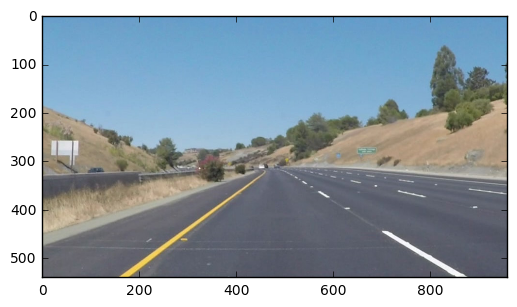

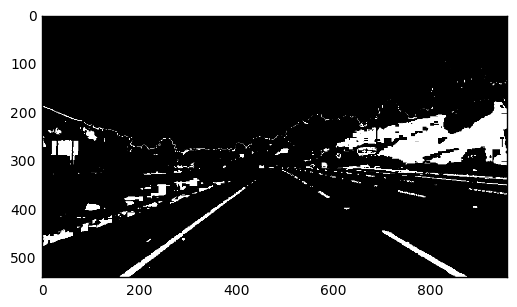

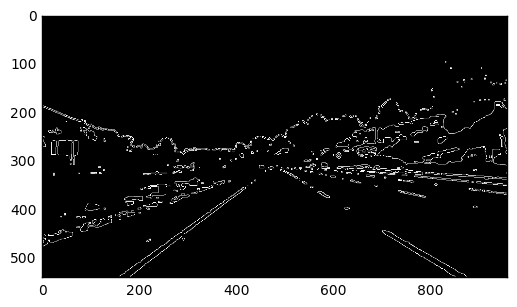

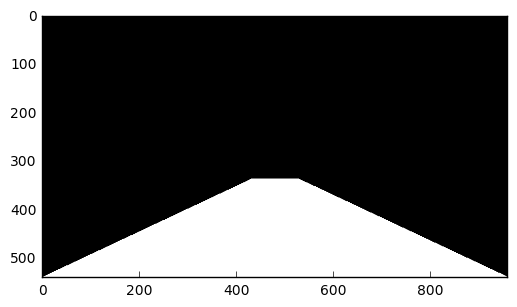

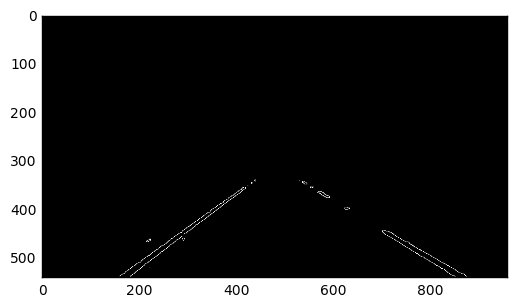

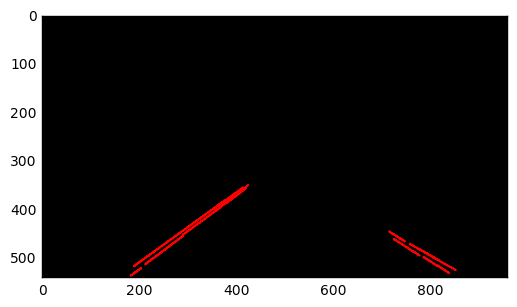

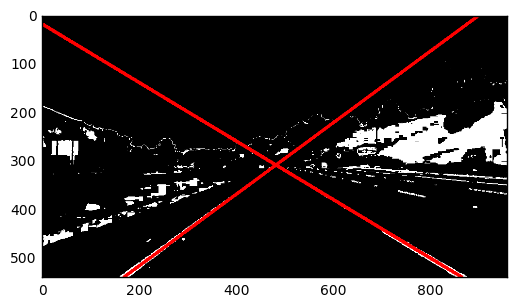

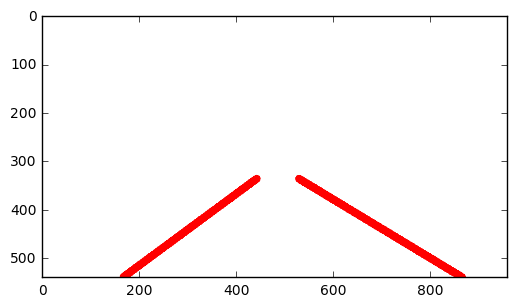

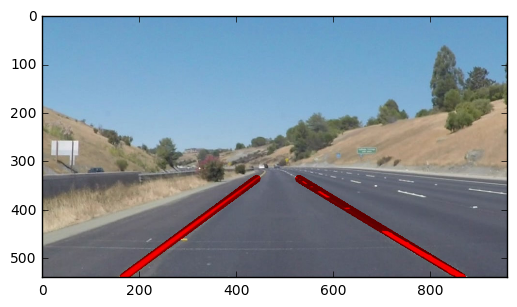

In [3]:
#PROCESS SAMPLE IMAGES
#Test Image Number select any number from 0 to 5
ImageNumber=3
imgName=os.listdir("test_images/")
imgPath='test_images/'
imgFullName=imgPath + imgName[ImageNumber]
Image1=img.imread(imgFullName)
pyplot.imshow(Image1)
pyplot.show()
for i in range(8):
    Image2=process_image(Image1,i)
    dimensions=(numpy.size(numpy.shape(Image2)))
    if dimensions==3:
        pyplot.imshow(Image2)
        pyplot.show()
    else:
        pyplot.imshow(Image2,cmap='gray')
        pyplot.show()

TEST THE VIDEO FILES

In [ ]:
#RIGHT SOLID LANE
white_output = 'outVideo_white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
Yellow_output = 'outVideo_yellow.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
Yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time Yellow_clip.write_videofile(Yellow_output, audio=False)

In [ ]:
Challenge_output = 'challenge.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
Challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time Challenge_clip.write_videofile(Challenge_output, audio=False)